# 1. Import

In [228]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from mca import MCA
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import csv
import plotly.express as px

# 2. Load and parse the data

## Load the data

In [181]:
data = pd.read_csv('../data/FlightData.csv')
data

,from_airport_code,from_country,dest_airport_code,dest_country,aircraft_type,airline_number,airline_name,flight_number,departure_time,arrival_time,duration,stops,price,currency,co2_emissions,avg_co2_emission_for_this_route,co2_percentage,scan_date
0,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Airbus A330|Airbu...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1320000.0,1320000.0,0%,2022-04-29 17:52:59
1,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Boeing 787|Airbus...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1195000.0,1320000.0,-9%,2022-04-29 17:52:59
2,ALG,Algeria,AEP,Argentina,Airbus A320|Airbus A321|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1855|AF1855|AF1855|AF1855,2022-04-30 12:45:00,2022-05-01 10:15:00,1530,3,1284.0,USD,1248000.0,1320000.0,-5%,2022-04-29 17:52:59
3,ALG,Algeria,AEP,Argentina,Airbus A318|Airbus A320|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1290.0,USD,1347000.0,1320000.0,2%,2022-04-29 17:52:59
4,ALG,Algeria,AEP,Argentina,Airbus A321neo|Boeing 777|Airbus A320,multi,[Lufthansa| LATAM],LH1317|LH1317|LH1317,2022-04-30 12:35:00,2022-05-01 10:15:00,1540,2,1347.0,USD,1381000.0,1320000.0,4%,2022-04-29 17:52:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998861,BOM,India,SYD,Australia,Boeing 777|Airbus A380,EK,[Emirates],EK503|EK503,2022-05-01 19:20:00,2022-05-02 22:05:00,1335,1,1317.0,USD,1567000.0,1133000.0,38%,2022-04-29 17:52:59
998862,BOM,India,SYD,Australia,Boeing 777|Airbus A380,EK,[Emirates],EK509|EK509,2022-05-01 22:20:00,2022-05-02 22:05:00,1155,1,1317.0,USD,1583000.0,1133000.0,39%,2022-04-29 17:52:59
998863,BOM,India,SYD,Australia,Airbus A350|Boeing 787|Boeing 737,multi,[Etihad| Virgin Australia],EY205|EY205|EY205,2022-05-01 04:35:00,2022-05-02 09:55:00,1490,2,1328.0,USD,1354000.0,1133000.0,19%,2022-04-29 17:52:59
998864,BOM,India,SYD,Australia,Airbus A321 (Sharklets)|Airbus A321|Airbus A330,multi,[Air India| SriLankan],AI603|AI603|AI603,2022-05-01 06:10:00,2022-05-02 14:55:00,1695,2,1368.0,USD,1099000.0,1133000.0,-2%,2022-04-29 17:52:59


## Remove the irrelevant columns
We will try to redict the co2 emissions based on the all the other columns.

We will remove the following columns:
- departure_time, arrival_time: The type is datetime, and we don't handle datetime columns
- currency: The currency doesn't have any effect on the other columns
- from_country, dest_country: The country doesn't have any effect on the other columns, and we can find the country from the airport code
- flight_number: The flight number doesn't have any effect on the co2 emissions
- scan_date: The scan date doesn't have any effect on the co2 emissions
- airline_name: The airline name doesn't have any effect on the co2 emissions and we can find the airline name from the airline number

The following columns could be removed to make it harder to predict the co2 emissions:
- co2_percentage
- avg_co2_emission_for_this_route
Together, it is very easy to predict the co2 emissions based on these columns, but we will keep them for now. If we see that it is too easy to predict the co2 emissions, we will remove these columns. and try again.

## Save the preprocessed data to a new file

In [182]:
data = data.drop(['departure_time','flight_number','arrival_time','scan_date','currency','from_country','dest_country', 'airline_name'], axis=1)
data.to_csv('../data/PreprocessedFlightData.csv', index=False)

## Reduce the size of the dataset

the dataset has almost 1 million rows, this is too much for our computer to handle. We will reduce the size of the dataset to 10000 to make it easier to work with. we can always change the size of the dataset later if we need to.

In [183]:
# Take the large dataset and create a smaller subset of it.

input_file_path = '../data/PreprocessedFlightData.csv'
reduced_flight_data_path = '../data/ReducedFlightData.csv'

if os.path.exists(reduced_flight_data_path):
    os.remove(reduced_flight_data_path)

# choose how many rows to copy
rows_to_copy = 10000

# Method 1: using csv reader and writer

with open(input_file_path, 'r') as input_file, open(reduced_flight_data_path, 'w', newline='') as output_file:
    csv_reader = csv.reader(input_file)
    csv_writer = csv.writer(output_file)

    header = next(csv_reader)
    csv_writer.writerow(header)

    all_rows = list(csv_reader)

    rows_to_copy = min(rows_to_copy, len(all_rows))

    random_rows = random.sample(all_rows, rows_to_copy)
    for row in random_rows:
        csv_writer.writerow(row)

# Method 2: using pandas sample(VERY SLOW)
# pd.DataFrame.sample(
#     pd.read_csv(input_file_path),
#     n=6000,
#     random_state=42
# ).to_csv(reduced_flight_data_path, index=False)


print(f'Copied {rows_to_copy} random rows from {input_file_path} to {reduced_flight_data_path}')

Copied 10000 random rows from ../data/PreprocessedFlightData.csv to ../data/ReducedFlightData.csv


# 3. Split the data into train and test sets

In [184]:
data = pd.read_csv("../data/ReducedFlightData.csv")
full_data = pd.read_csv("../data/PreprocessedFlightData.csv")
train_size = round(data.shape[0] * 0.7)

train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# 4. Fill missing values

In [185]:
pd.DataFrame({
    'Na amount': data.isna().sum(),
    'Na percentage': data.isna().sum()/test_data.shape[0]
})

,Na amount,Na percentage
from_airport_code,0,0.000000
dest_airport_code,0,0.000000
aircraft_type,143,0.047667
airline_number,0,0.000000
duration,0,0.000000
stops,0,0.000000
price,13,0.004333
co2_emissions,51,0.017000
avg_co2_emission_for_this_route,925,0.308333
co2_percentage,925,0.308333


Here are all the columns with missing values and the way we will fill them:
- aircraft_type: we can fill the missing values with the most common aircraft type for the given route, airline and number of stops
- price: we can fill the missing values with the average price for the given route, airline and number of stops
- co2_emissions: we can fill the missing values with the average co2 emissions for the given route, airline and number of stops
- avg_co2_emission_for_this_route: we can fill the missing values with the average co2 emissions for the given route, airline and number of stops
- co2_percentage: we can fill the missing values with the average co2 emissions for the given route, airline and number of stops

In [186]:
for i, row in data[data['aircraft_type'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) & 
              (full_data['dest_airport_code'] == row['dest_airport_code']) & 
              (full_data['stops'] == row['stops']) &
              (full_data['airline_number'] == row['airline_number'])]

    if subset['aircraft_type'].isnull().sum() != subset.shape[0]:
        most_common_aircraft_type = subset['aircraft_type'].value_counts().idxmax()
        data.loc[i, 'aircraft_type'] = most_common_aircraft_type

In [187]:
for i, row in data[data['price'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) & 
              (full_data['dest_airport_code'] == row['dest_airport_code']) & 
              (full_data['stops'] == row['stops']) &
              (full_data['airline_number'] == row['airline_number'])]

    if subset['price'].isnull().sum() != subset.shape[0]:
        avg_price = subset['price'].mean()
        data.loc[i, 'price'] = avg_price

In [188]:
for i, row in data[data['co2_emissions'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) & 
              (full_data['dest_airport_code'] == row['dest_airport_code']) & 
              (full_data['stops'] == row['stops']) &
              (full_data['airline_number'] == row['airline_number'])]

    if subset['co2_emissions'].isnull().sum() != subset.shape[0]:
        avg_co2_emissions = subset['co2_emissions'].mean()
        data.loc[i, 'co2_emissions'] = avg_co2_emissions

We can see that for some routes and number of stops, there are no values for the avg co2 emissions and the co2 percentage. We will fill these values with the average co2 emissions and co2 percentage for the given route and number of stops.

In [189]:
subset = full_data[(full_data['duration'] <= 3085+100) & 
          (full_data['duration'] >= 3085-100) & 
          (full_data['stops'] == 2) &
          (full_data['airline_number'] == 'multi') &
                   (full_data['aircraft_type'] == 'Boeing 777|Boeing 777|Airbus A330')]
subset

,from_airport_code,dest_airport_code,aircraft_type,airline_number,duration,stops,price,co2_emissions,avg_co2_emission_for_this_route,co2_percentage
394,ALG,MEL,Boeing 777|Boeing 777|Airbus A330,multi,3105,2,1688.0,1780000.0,NaN,NaN
395,ALG,MEL,Boeing 777|Boeing 777|Airbus A330,multi,3105,2,1712.0,1780000.0,NaN,NaN
466,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,3125,2,1551.0,1828000.0,NaN,NaN
469,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,3145,2,1556.0,1803000.0,NaN,NaN
470,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,3145,2,1564.0,1803000.0,NaN,NaN
479,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,3100,2,3156.0,1939000.0,NaN,NaN
745,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,3150,2,3179.0,1939000.0,NaN,NaN
261541,GRU,SGN,Boeing 777|Boeing 777|Airbus A330,multi,3085,2,1343.0,2222000.0,2063000.0,7%
261855,GRU,SGN,Boeing 777|Boeing 777|Airbus A330,multi,3085,2,1186.0,2222000.0,2063000.0,7%
564450,CPH,CNF,Boeing 777|Boeing 777|Airbus A330,multi,3170,2,1668.0,2071000.0,1240000.0,67%


After doing some research, we found that trips with the same duration, number of stops, airline number and aircraft type have very different average co2 emissions. Earlier we saw that it could be a possibility to remove the avg co2 emissions and co2 percentage columns, so we will do that now.

In [190]:
data = data.drop(['avg_co2_emission_for_this_route','co2_percentage'], axis=1)

In [191]:
pd.DataFrame({
    'Na amount': data.isna().sum(),
    'Na percentage': data.isna().sum() / test_data.shape[0]
})

,Na amount,Na percentage
from_airport_code,0,0.000
dest_airport_code,0,0.000
aircraft_type,45,0.015
airline_number,0,0.000
duration,0,0.000
stops,0,0.000
price,9,0.003
co2_emissions,3,0.001


For the remaining missing values, we will create one dataset where we deleted the missing values and one dataset where we filled the missing values with the average or max value for the given route and number of stops. We will then compare the two datasets and see which one is better.

### Method 1: Delete the avg co2 emissions and co2 percentage columns

In [192]:
data_deleted_na = data.dropna()
data_deleted_na.to_csv('../data/processedData/deleted_na.csv', index=False)
data_deleted_na.info() # we deleted 67 rows or 0.0067% of the data

<class 'pandas.core.frame.DataFrame'>
Index: 9945 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   from_airport_code  9945 non-null   object 
 1   dest_airport_code  9945 non-null   object 
 2   aircraft_type      9945 non-null   object 
 3   airline_number     9945 non-null   object 
 4   duration           9945 non-null   int64  
 5   stops              9945 non-null   int64  
 6   price              9945 non-null   float64
 7   co2_emissions      9945 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 699.3+ KB


### Method 2: Fill the missing values with the average or max value for the given route and number of stops

In [193]:
for i, row in data[data['aircraft_type'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) &
                       (full_data['dest_airport_code'] == row['dest_airport_code']) &
                       (full_data['stops'] == row['stops'])]

    if subset['aircraft_type'].isnull().sum() != subset.shape[0]:
        most_common_aircraft_type = subset['aircraft_type'].value_counts().idxmax()
        data.loc[i, 'aircraft_type'] = most_common_aircraft_type

    most_common_aircraft_type = full_data['aircraft_type'].value_counts().idxmax()
    data.loc[i, 'aircraft_type'] = most_common_aircraft_type

In [204]:
for i, row in data[data['price'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) &
                       (full_data['dest_airport_code'] == row['dest_airport_code']) &
                       (full_data['stops'] == row['stops'])]

    if subset['price'].isnull().sum() != subset.shape[0]:
        avg_price = subset['price'].mean()
        data.loc[i, 'price'] = avg_price
        
    avg_price = full_data['price'].mean()
    data.loc[i, 'price'] = avg_price

In [195]:
for i, row in data[data['co2_emissions'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) &
                       (full_data['dest_airport_code'] == row['dest_airport_code']) &
                       (full_data['stops'] == row['stops'])]

    if subset['co2_emissions'].isnull().sum() != subset.shape[0]:
        avg_co2_emissions = subset['co2_emissions'].mean()
        data.loc[i, 'co2_emissions'] = avg_co2_emissions

In [205]:
data.to_csv('../data/processedData/filled_na.csv', index=False)
data_filled_na = pd.read_csv('../data/processedData/filled_na.csv')
data_filled_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   from_airport_code  10000 non-null  object 
 1   dest_airport_code  10000 non-null  object 
 2   aircraft_type      10000 non-null  object 
 3   airline_number     10000 non-null  object 
 4   duration           10000 non-null  int64  
 5   stops              10000 non-null  int64  
 6   price              10000 non-null  float64
 7   co2_emissions      10000 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 625.1+ KB


## We will first start with the deleted_na dataset

## Fix the data types of the columns

In [206]:
data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops']] = data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops']].astype('category')
data_deleted_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9945 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   from_airport_code  9945 non-null   category
 1   dest_airport_code  9945 non-null   category
 2   aircraft_type      9945 non-null   category
 3   airline_number     9945 non-null   category
 4   duration           9945 non-null   int64   
 5   stops              9945 non-null   category
 6   price              9945 non-null   float64 
 7   co2_emissions      9945 non-null   float64 
dtypes: category(5), float64(2), int64(1)
memory usage: 533.9 KB


C:\Users\noahd\AppData\Local\Temp\ipykernel_11516\4194349430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops']] = data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops']].astype('category')


## Label encode the categorical columns

In [209]:
label_encoder = LabelEncoder()

data_deleted_na['from_airport_code'] = label_encoder.fit_transform(data_deleted_na['from_airport_code'])
data_deleted_na['dest_airport_code'] = label_encoder.fit_transform(data_deleted_na['dest_airport_code'])
data_deleted_na['aircraft_type'] = label_encoder.fit_transform(data_deleted_na['aircraft_type'])
data_deleted_na['airline_number'] = label_encoder.fit_transform(data_deleted_na['airline_number'])
data_deleted_na['stops'] = label_encoder.fit_transform(data_deleted_na['stops'])

data_deleted_na.head()

C:\Users\noahd\AppData\Local\Temp\ipykernel_11516\2376093141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deleted_na['from_airport_code'] = label_encoder.fit_transform(data_deleted_na['from_airport_code'])
C:\Users\noahd\AppData\Local\Temp\ipykernel_11516\2376093141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deleted_na['dest_airport_code'] = label_encoder.fit_transform(data_deleted_na['dest_airport_code'])
C:\Users\noahd\AppData\Local\Temp\ipykernel_11516\2376093141.py:5: SettingWi

,from_airport_code,dest_airport_code,aircraft_type,airline_number,duration,stops,price,co2_emissions
0,14,11,2779,100,1155,2,4027.0,1733000.0
1,12,48,2540,100,1985,2,1114.0,2083000.0
2,15,40,2422,85,1199,1,771.0,849000.0
3,4,29,577,100,858,2,1099.0,673000.0
4,22,33,857,100,1385,1,1504.0,248000.0


## Split the data into train and validation sets

In [198]:
train_size = round(data_deleted_na.shape[0] * 0.7)

train_data_deleted_na = data_deleted_na.iloc[:train_size].copy()
validation_data_deleted_na = data_deleted_na.iloc[train_size:].copy()

## Normalizing the data 

The different columns have very different ranges, so we will normalize the data to make it easier to work with.

We will normalize the data by subtracting the mean and dividing by the standard deviation.

In [199]:
mean_values = train_data_deleted_na[['duration', 'price', 'co2_emissions']].mean()
std_values = train_data_deleted_na[['duration', 'price', 'co2_emissions']].std()

train_data_deleted_na[['duration', 'price', 'co2_emissions']] = (train_data_deleted_na[['duration', 'price', 'co2_emissions']] - mean_values) / std_values
validation_data_deleted_na[['duration', 'price', 'co2_emissions']] = (validation_data_deleted_na[['duration', 'price', 'co2_emissions']] - mean_values) / std_values

train_data_deleted_na.head(), validation_data_deleted_na.head()

(  from_airport_code dest_airport_code                        aircraft_type  \
 0               DEL               BRU   Boeing 787|Airbus A330|Airbus A320   
 1               CPH               MEL    Boeing 777|Airbus A380|Boeing 737   
 2               DUB               LAX             Boeing 767|Boeing 787-10   
 3               BOG               FLL  Airbus A320|Airbus A320|Airbus A320   
 4               PVG               HND               Airbus A320|Boeing 787   
 
   airline_number  duration stops     price  co2_emissions  
 0          multi -0.443600     2  1.078754       0.636912  
 1          multi  0.743546     2 -0.323401       0.993899  
 2             UA -0.380667     1 -0.488502      -0.264736  
 3          multi -0.868398     2 -0.330621      -0.444249  
 4          multi -0.114632     1 -0.135676      -0.877734  ,
      from_airport_code dest_airport_code  \
 7004               VIE               LHR   
 7005               BOG               MEX   
 7006               FR

# 5. Feature engineering

## Multiple correspondence analysis (MCA)

In [220]:
data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops']].head()

,from_airport_code,dest_airport_code,aircraft_type,airline_number,stops
0,14,11,2779,100,2
1,12,48,2540,100,2
2,15,40,2422,85,1
3,4,29,577,100,2
4,22,33,857,100,1


In [225]:
# Assuming 'data_encoded' is your DataFrame with encoded categorical features
mca_model = MCA(data_deleted_na[['from_airport_code', 'dest_airport_code', 'aircraft_type', 'airline_number', 'stops']], benzecri=False, TOL=1e-4)

# Access the results, including coordinates for rows and columns
row_coordinates = mca_model.fs_r(N=3)  # Row coordinates for the first 3 dimensions
column_coordinates = mca_model.fs_c(N=3)  # Column coordinates for the first 3 dimensions
explained_variance = mca_model.expl_var(greenacre=False)

print(row_coordinates, column_coordinates, explained_variance)

[[-1.23568984e-01  7.05234893e-02  4.50923716e-03]
 [-6.09705688e-02  8.37576854e-05  3.04692821e-02]
 [-8.10319417e-02  3.69065115e-04  9.84824756e-03]
 ...
 [ 7.19594382e-01  1.88758039e-01  1.21218497e-01]
 [-8.46956368e-02  1.36871609e-02  6.11337572e-03]
 [ 8.01721293e-02 -3.45161108e-02  8.15874419e-02]] [[ 6.41221849e-01 -8.54904001e-02 -7.72300519e-01]
 [ 8.38128994e-01 -6.13812523e-01  1.07808616e-01]
 [-6.80267002e-02  2.55562792e-04  1.58256936e-03]
 [ 8.43830930e-01  2.96798417e-01  6.33379431e-02]
 [ 7.49315871e-01  9.24501850e-02 -6.47840291e-02]] [7.56820269e-01 1.64761249e-01 7.49691825e-02 3.44929995e-03
 1.86012576e-31]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


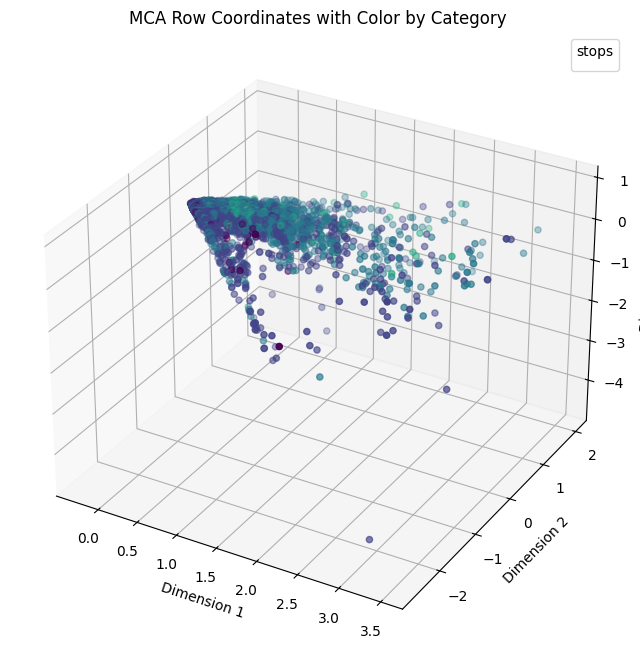

In [241]:
# Assuming 'data_encoded' is the original DataFrame with encoded categorical features
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Adjusting the third dimension (z) in the scatter plot
ax.scatter(row_coordinates[:, 0], row_coordinates[:, 1], row_coordinates[:, 2], c=data_deleted_na['stops'], cmap='viridis')

ax.set_title('MCA Row Coordinates with Color by Category')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend(title='stops')

plt.show()

We saw through experimentation that the categorical data are not that correlated individually, it is when we combine them that we get a better correlation. We will therefore combine the categorical data into one column.

## Principal component analysis (PCA)

array([ 70.78542688,  91.83571633, 100.        ])

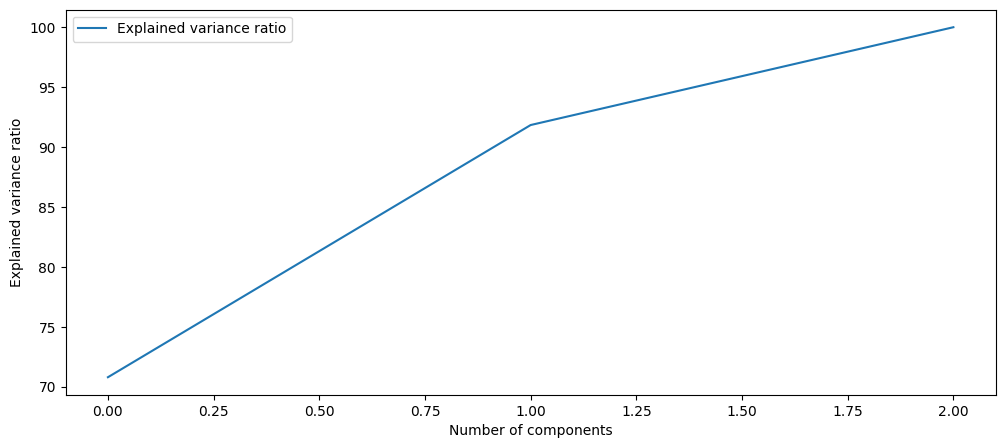

In [200]:
pca = PCA()
pca.fit(train_data_deleted_na[['duration', 'price', 'co2_emissions']])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pca.explained_variance_ratio_.cumsum()*100,
        label="Explained variance ratio")
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance ratio")
ax.legend()
pca.explained_variance_ratio_.cumsum()*100

We can see that the first 2 components explain 90% of the variance, so we will use 2 components.

In [201]:
pca = PCA(n_components=2)
pca.fit(train_data_deleted_na[['duration', 'price', 'co2_emissions']])

PCA(n_components=2)

In [202]:
train_data_deleted_pca = pd.DataFrame(pca.transform(train_data_deleted_na[['duration', 'price', 'co2_emissions']]), index=train_data_deleted_na.index, columns=['PC1', 'PC2'])
validation_data_deleted_pca = pd.DataFrame(pca.transform(validation_data_deleted_na[['duration', 'price', 'co2_emissions']]), index=validation_data_deleted_na.index, columns=['PC1', 'PC2'])

train_data_deleted_pca.head(), validation_data_deleted_pca.head()

(        PC1       PC2
 0  0.826646  1.015116
 1  0.791950 -0.491277
 2 -0.649750  0.048671
 3 -0.908914  0.483720
 4 -0.683912 -0.209327,
            PC1       PC2
 7004 -1.689184  0.565333
 7005 -1.029511 -0.138443
 7006 -1.678117  0.687417
 7007 -0.978527 -0.354485
 7008  0.953525 -0.295497)

In [203]:
train_data_deleted_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6962 entries, 0 to 7003
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   from_airport_code  6962 non-null   category
 1   dest_airport_code  6962 non-null   category
 2   aircraft_type      6962 non-null   category
 3   airline_number     6962 non-null   category
 4   duration           6962 non-null   float64 
 5   stops              6962 non-null   category
 6   price              6962 non-null   float64 
 7   co2_emissions      6962 non-null   float64 
dtypes: category(5), float64(3)
memory usage: 423.2 KB
